In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import f1_score, silhouette_score, silhouette_samples
from scipy.spatial.distance import cosine
from scipy.cluster.vq import kmeans, vq

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, LSTM, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4912582946115833634
xla_global_id: -1
]


In [4]:
# Create relative path method to access all the files in data/raw/train folder
def relative_path(path):
    return os.path.join(os.getcwd(), path)

In [5]:
def evaluate(final_df, stream,final_predictions):
    # Calculate F1 Score
    f1 = f1_score(final_df['actual_anomaly'], final_df['predicted_labels'])
    print(f"F1 Score: {f1}")
    # True Positives
    tp_filter = (final_df['actual_anomaly'] == 1) & (final_df['predicted_labels'] == 1)
    # True Negatives
    tn_filter = (final_df['actual_anomaly'] == 0) & (final_df['predicted_labels'] == 0)
    # False Positives
    fp_filter = (final_df['actual_anomaly'] == 0) & (final_df['predicted_labels'] == 1)
    # False Negatives
    fn_filter = (final_df['actual_anomaly'] == 1) & (final_df['predicted_labels'] == 0)
    # Precision
    precision = len(final_df[tp_filter]) / (len(final_df[tp_filter]) + len(final_df[fp_filter]))
    # Recall
    recall = len(final_df[tp_filter]) / (len(final_df[tp_filter]) + len(final_df[fn_filter]))
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f'False Negatives: {len(final_df[fn_filter])}')
    print(f'False Positives: {len(final_df[fp_filter])}')
    print(f'True Negatives: {len(final_df[tn_filter])}')
    print(f'True Positives: {len(final_df[tp_filter])}')
    
    # Add evaluation Metrics to .csv file for on sample where chan_id == stream
    final_predictions.loc[final_predictions['chan_id'] == stream, 'f1'] = f1
    final_predictions.loc[final_predictions['chan_id'] == stream, 'precision'] = precision
    final_predictions.loc[final_predictions['chan_id'] == stream, 'recall'] = recall
    final_predictions.loc[final_predictions['chan_id'] == stream, 'tp'] = len(final_df[tp_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'tn'] = len(final_df[tn_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'fp'] = len(final_df[fp_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'fn'] = len(final_df[fn_filter])
    
    # calculate range or sequence of anomalies predicted
    predicted_anomalies = []
    start = 0
    end = 0
    while end < len(final_df):
        slice = final_df.iloc[start:end+1]
        if not slice.empty:
            if slice['predicted_labels'].iloc[0] == 1:
                if start == 0:
                    start = end
            else:
                if start != 0:
                    end = end - 1
                    predicted_anomalies.append([start,end])
                    start = 0
        if end < len(final_df):
            end += 1
    final_predictions.loc[final_predictions['chan_id'] == stream, 'predicted_anomalies'] = str(predicted_anomalies)
    return final_predictions

In [6]:
def train_autoencoder(train_df, test_df):
    # Split the data into train and test sets
    X_train, X_test = train_test_split(train_df.values, test_size=0.2, random_state=42)
    
    # Define the dimensions of the latent space
    latent_dim = 8
    input_dim = train_df.shape[1]
    
    # Create an autoencoder model with dropout layers
    # Do not use dropouts.  For some reason we can't build clusters when using dropout
    input_layer = keras.Input(shape=(train_df.shape[1],))
    encoded = layers.Dense(32, activation='relu', activity_regularizer=regularizers.l1(0.01))(input_layer)
    encoded = layers.Dense(16, activation='relu', activity_regularizer=regularizers.l1(0.01))(encoded)
    
    # Latent layer with attention
    latent_layer = Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(0.01))(encoded)
    

    # Decoder
    decoded = layers.Dense(16, activation='relu', activity_regularizer=regularizers.l1(0.01))(latent_layer)
    decoded = layers.Dense(32, activation='relu', activity_regularizer=regularizers.l1(0.01))(decoded)
    decoded = layers.Dense(input_dim, activation='tanh')(decoded)

    autoencoder = keras.Model(input_layer, decoded)

    # Compile the autoencoder with gradient clipping
    optimizer = Adam(clipnorm=1.0)  # Clip gradients by their norm
    autoencoder.compile(optimizer=optimizer, loss='mse')

    # Define Early Stopping and Reduce Learning Rate callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    # Train the autoencoder with callbacks
    history = autoencoder.fit(
        X_train, X_train,
        epochs=300,
        batch_size=32,
        shuffle=True,
        validation_data=(X_test, X_test),  # Validation data for early stopping
        callbacks=[early_stopping, reduce_lr]  # Pass the callbacks
    )

    encoder = keras.Model(input_layer, encoded)
    # Encode entire dataset
    test_latent_representation = encoder.predict(test_df.values)
    train_latent_representation = encoder.predict(train_df.values)
    return test_latent_representation, train_latent_representation, autoencoder

In [7]:
def get_reconstruction_loss(autoencoder, test_df,final_df):
    max_window_size = 100
    recon_losses = []
    start = 0
    end = 0

    while end < len(test_df):
        slice = test_df.iloc[start:end+1]
        print(f"Processing slice: Start = {start}, End = {end}, Shape = {slice.shape}")

        # Check if the slice is empty
        if not slice.empty:
            # Reconstruct slice
            recon = autoencoder.predict(slice.values)
            print(f"Reconstructed shape: {recon.shape}")

            # Calculate recon loss for the entire slice
            loss = np.mean(np.square(slice.values - recon), axis=1)
            mean_loss = np.mean(loss)
            recon_losses.append(mean_loss)

        # Increment the start by 1 if the end is greater than or equal to the max window size
        if end >= max_window_size:
            start += 1

        # Check if end has reached the end of the DataFrame
        if end < len(test_df):
            end += 1
    final_df['recon_losses'] = recon_losses
    return final_df

In [8]:
def perform_kmeans_with_refinement(test_latent_representation, train_latent_representation, k_values, final_df, max_iter=400, random_state=42):
    """
    Perform K-Means clustering with iterative refinement based on silhouette score.

    Parameters:
    - X: Input data (features) as a DataFrame or numpy array.
    - k_values: List of K values to consider.
    - n_init: Number of times the K-Means algorithm will be run with different centroid seeds.
    - max_iter: Maximum number of iterations for each run of the K-Means algorithm.
    - random_state: Seed for randomization (optional).

    Returns:
    - Tuple containing (best_K, best_score, cluster_labels).
    """
    
    if isinstance(test_latent_representation, pd.DataFrame):
        test_latent_representation = test_latent_representation.values  # if dataframe Convert DataFrame to numpy array

    if isinstance(train_latent_representation, pd.DataFrame):
        train_latent_representation = train_latent_representation.values  # if dataframe Convert DataFrame to numpy array
    
    scaler = StandardScaler()
    train_latent_representation = scaler.fit_transform(train_latent_representation)
    test_latent_representation = scaler.transform(test_latent_representation)
    
    best_k = None
    best_silhouette_score = -1

    for k in k_values:
        print(f"Current k value: {k}")
        kmeans = KMeans(n_clusters=k, n_init=100, init='k-means++', max_iter=max_iter, random_state=random_state).fit(train_latent_representation)
        labels = kmeans.predict(train_latent_representation)

        # Calculate the silhouette score
        silhouette_values = silhouette_samples(train_latent_representation, labels, metric='euclidean')

        # Calculate the weighted average of the silhouette coefficients
        silhouette_avg = np.mean(silhouette_values)
        print(f"Silhouette score: {silhouette_avg}")

        # Check if this is the best silhouette score so far
        if silhouette_avg > best_silhouette_score:
            best_k = k
            best_silhouette_score = silhouette_avg

    
    print(f"Best K: {best_k}")
    print(f"Best Silhouette Score: {best_silhouette_score}")
    
    kmeans = KMeans(n_clusters=best_k, n_init=100, init='k-means++',max_iter=max_iter,random_state=random_state).fit(train_latent_representation)

    # Predicting the cluster labels for the test set
    cluster_labels = kmeans.predict(test_latent_representation)

    # Computing the distances of samples in test set to all cluster centers
    distances = kmeans.transform(test_latent_representation)

    # Extracting the distances of each sample to its assigned cluster
    distances_to_assigned_cluster = distances[np.arange(len(distances)), cluster_labels]
    cluster_centers = kmeans.cluster_centers_
    # Graph Cluster_centers
    plt.figure(figsize=(10, 6))
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='r')
    plt.title('Cluster Centers')
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.show()
    final_df['anomaly_score'] = distances_to_assigned_cluster
    return final_df

In [9]:
import matplotlib.patches as patches

def perform_thresholding(final_df):
    X = final_df[['anomaly_score', 'recon_losses']].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Separate the normal and anomalous points
    normal_points = X[final_df['actual_anomaly'] == 0]
    anomalous_points = X[final_df['actual_anomaly'] == 1]

    # Create separate scatter plots for the normal and anomalous points
    plt.scatter(normal_points[:, 0], normal_points[:, 1], c='blue', label='Normal')
    plt.scatter(anomalous_points[:, 0], anomalous_points[:, 1], c='red', label='Anomalous')

    plt.xlabel('Anomaly Score')
    plt.ylabel('Reconstruction Loss')

    nbrs = NearestNeighbors(n_neighbors=6000)
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)

    threshold = np.mean(distances)

    # Add a circle representing the decision boundary
    circle = patches.Circle((0, 0), threshold, fill=False, color='green')
    plt.gca().add_patch(circle)

    # Add a legend
    plt.legend()

    plt.show()

    predicted_labels = np.where(distances.mean(axis=1) > threshold, 1, 0)
    final_df['predicted_labels'] = predicted_labels

    return final_df


In [10]:
def distances_recon_concat_ground_truth(final_df, labeled_anomalies, stream):
    anomaly_sequences = labeled_anomalies[labeled_anomalies['chan_id'] == stream]['anomaly_sequences'].tolist()
    actual_anomalies = [eval(seq) for seq in anomaly_sequences]
    
    # Initialize a binary array with zeros
    binary_labels = np.zeros(final_df.shape[0])

    # Check if actual_anomalies is a nested list
    if len(actual_anomalies) == 1 and isinstance(actual_anomalies[0], list) and len(actual_anomalies[0]) == 1:
        # Handle nested structure
        anomaly_sequence = actual_anomalies[0][0]
        start, end = anomaly_sequence[0], anomaly_sequence[1]
        binary_labels[start:end + 1] = 1
    else:
        # Handle non-nested structure (single-index anomalies)
        for sequence in actual_anomalies:
            if isinstance(sequence, int):
                binary_labels[sequence] = 1
    binary_frame = pd.DataFrame(binary_labels, columns=['actual_anomaly'])
    
    # Concatenate the DataFrames
    final_df = pd.concat([final_df, binary_frame], axis=1)
    return final_df

In [11]:
parent_dir = os.path.dirname(os.getcwd())
numpy_path = os.path.join(parent_dir, 'data/raw/train')

# Specify the files you want to concatenate
numpy_files = ['D-1.npy', 'D-2.npy', 'D-3.npy']

# Create a dataframe that concatenates the specified numpy files and reset the index
train_df = pd.DataFrame()
for file in numpy_files:
    numpy_file = np.load(os.path.join(numpy_path, file))
    # if numpy_file has 25 features then concat
    if numpy_file.shape[1] == 25:
        train_df = pd.concat([train_df, pd.DataFrame(numpy_file)])
    else:
        print(f"Skipping {file} as it has {numpy_file.shape[1]} features")
train_df = train_df.reset_index(drop=True)

In [12]:
train_df.shape

(8609, 25)

Currently working on D-4 Channel
Epoch 1/300
216/216 [==============================] - 2s 3ms/step - loss: 0.0503 - val_loss: 0.0350 - lr: 0.0010
Epoch 2/300
216/216 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0302 - lr: 0.0010
Epoch 3/300
216/216 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0236 - lr: 0.0010
Epoch 4/300
216/216 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0186 - lr: 0.0010
Epoch 5/300
216/216 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0160 - lr: 0.0010
Epoch 6/300
216/216 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.0144 - lr: 0.0010
Epoch 7/300
216/216 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0131 - lr: 0.0010
Epoch 8/300
216/216 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0122 - lr: 0.0010
Epoch 9/300
216/216 [==============================] - 

c:\Users\AXW0J9E\.conda\envs\telemacluster\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (54) found smaller than n_clusters (55). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette score: 0.9640795588493347
Current k value: 56
Silhouette score: 0.9679442644119263
Current k value: 57
Silhouette score: 0.9656974673271179
Current k value: 58
Silhouette score: 0.9721990823745728
Current k value: 59
Silhouette score: 0.9528151154518127
Best K: 17
Best Silhouette Score: 0.9979965090751648


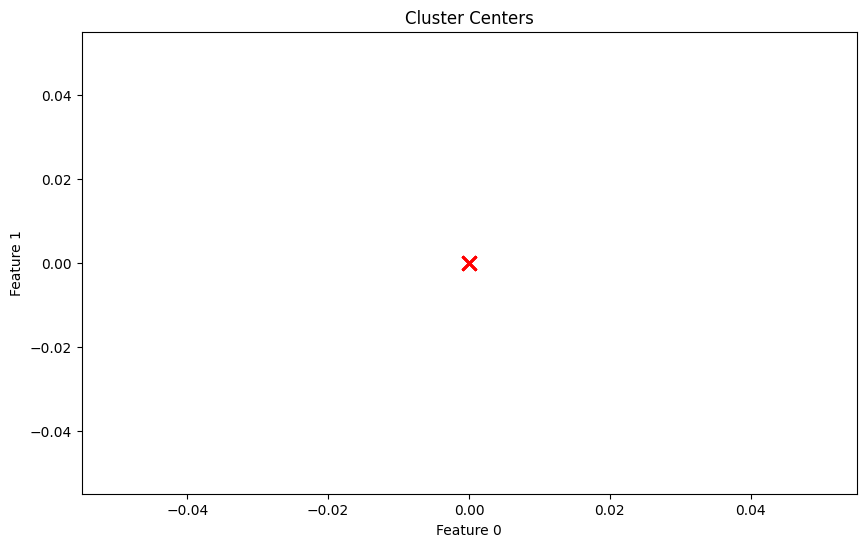

Processing slice: Start = 0, End = 0, Shape = (1, 25)
1/1 [==============================] - 0s 129ms/step
Reconstructed shape: (1, 25)
Processing slice: Start = 0, End = 1, Shape = (2, 25)
1/1 [==============================] - 0s 16ms/step
Reconstructed shape: (2, 25)
Processing slice: Start = 0, End = 2, Shape = (3, 25)
1/1 [==============================] - 0s 17ms/step
Reconstructed shape: (3, 25)
Processing slice: Start = 0, End = 3, Shape = (4, 25)
1/1 [==============================] - 0s 29ms/step
Reconstructed shape: (4, 25)
Processing slice: Start = 0, End = 4, Shape = (5, 25)
1/1 [==============================] - 0s 54ms/step
Reconstructed shape: (5, 25)
Processing slice: Start = 0, End = 5, Shape = (6, 25)
1/1 [==============================] - 0s 26ms/step
Reconstructed shape: (6, 25)
Processing slice: Start = 0, End = 6, Shape = (7, 25)
1/1 [==============================] - 0s 23ms/step
Reconstructed shape: (7, 25)
Processing slice: Start = 0, End = 7, Shape = (8, 25)


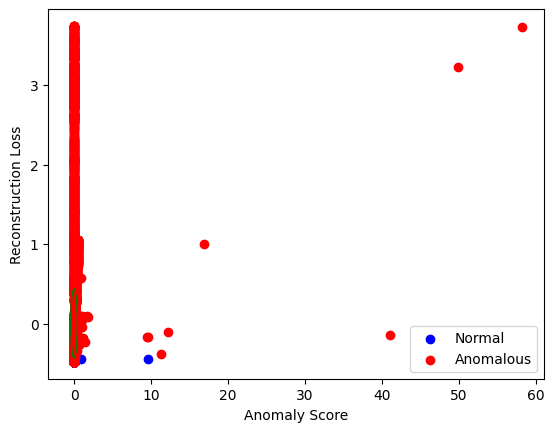

F1 Score: 0.6955649207304837
Precision: 0.9988472622478386
Recall: 0.5335591133004927
False Negatives: 1515
False Positives: 2
True Negatives: 5223
True Positives: 1733


C:\Users\AXW0J9E\AppData\Local\Temp\ipykernel_24424\1647934281.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6955649207304837' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_predictions.loc[final_predictions['chan_id'] == stream, 'f1'] = f1
C:\Users\AXW0J9E\AppData\Local\Temp\ipykernel_24424\1647934281.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9988472622478386' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_predictions.loc[final_predictions['chan_id'] == stream, 'precision'] = precision
C:\Users\AXW0J9E\AppData\Local\Temp\ipykernel_24424\1647934281.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5335591133004927' has dtype incompatible with int64, ple

In [13]:
parent_dir = os.path.dirname(os.getcwd())
channels_folder = os.path.join(parent_dir, 'data','raw','train')
channels = os.listdir(channels_folder)

labeled_anomalies_file = os.path.join(parent_dir, 'data','processed','labeled_anomalies.csv')
labeled_anomalies = pd.read_csv(labeled_anomalies_file)
test_channel = 'D-4.npy'

final_predictions = labeled_anomalies.copy()
# Add a columns for f1 score, precision, recall, tp, tn, fp, fn to final predictions dataframe
final_predictions['f1'] = 0
final_predictions['precision'] = 0
final_predictions['recall'] = 0
final_predictions['tp'] = 0
final_predictions['tn'] = 0
final_predictions['fp'] = 0
final_predictions['fn'] = 0
final_predictions['predicted_anomaly_sequences'] = 0
stream = test_channel[:-4]
final_df = pd.DataFrame()    
print(f'Currently working on {stream} Channel')

# Load the test data
test_df = pd.DataFrame(np.load(os.path.join(parent_dir, 'data','raw','test',f'{test_channel}')))

test_latent_representation, train_latent_representation, autoencoder = train_autoencoder(train_df, test_df)

# Perform K-Means clustering with iterative refinement based on silhouette score\
final_df  = perform_kmeans_with_refinement(test_latent_representation, train_latent_representation, range(3,60), final_df)
# Perform Sliding Window Autoencoder to get reconstruction loss
final_df  = get_reconstruction_loss(autoencoder, test_df,final_df)
final_df  = distances_recon_concat_ground_truth(final_df, labeled_anomalies, stream)
final_df  = perform_thresholding(final_df)
    
final_predictions = evaluate(final_df, stream, final_predictions)


In [14]:
telemetry = pd.DataFrame(test_df[0])
telemetry.columns = ['telemetry']
telemetry

,telemetry
0,-1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0
...,...
8468,1.0
8469,1.0
8470,1.0
8471,1.0


In [15]:
final_frame = pd.concat([final_df, telemetry], axis=1)
final_frame

,anomaly_score,recon_losses,actual_anomaly,predicted_labels,telemetry
0,0.000002,0.000245,0.0,0,-1.0
1,0.000002,0.000245,0.0,0,-1.0
2,0.000002,0.000245,0.0,0,-1.0
3,0.000002,0.000245,0.0,0,-1.0
4,0.000002,0.000245,0.0,0,-1.0
...,...,...,...,...,...
8468,0.044467,0.409001,1.0,1,1.0
8469,0.044467,0.409363,1.0,1,1.0
8470,0.299708,0.412529,1.0,1,1.0
8471,0.121078,0.413403,1.0,1,1.0


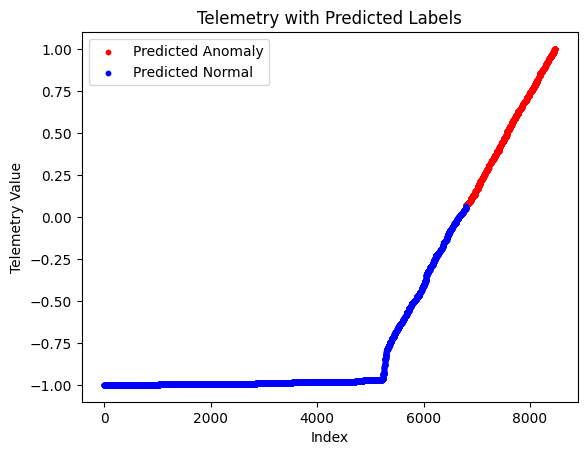

In [16]:
import matplotlib.pyplot as plt

# Sort the DataFrame by index
data = final_frame.sort_index()

# Split the data into two DataFrames based on the predicted_labels
data_red = data[data['predicted_labels'] == 1]
data_blue = data[data['predicted_labels'] == 0]

# Plot the red segments with smaller dots
plt.scatter(data_red.index, data_red['telemetry'], color='r', label='Predicted Anomaly', s=10)

# Plot the blue segments with smaller dots
plt.scatter(data_blue.index, data_blue['telemetry'], color='b', label='Predicted Normal', s=10)

# Add a title and labels to the plot
plt.title('Telemetry with Predicted Labels')
plt.xlabel('Index')
plt.ylabel('Telemetry Value')

# Display the legend
plt.legend()

# Display the plot
plt.show()